## Basic Imports

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import os, re
from collections import Counter

In [0]:
from scipy.stats import norm

In [0]:
from sklearn.metrics import mean_squared_error,mean_squared_log_error, r2_score
from math import sqrt

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [0]:
import spacy 
en_nlp = spacy.load('en')
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

## Data Loading

In [7]:
train = pd.read_csv('train.csv', encoding = 'utf-8')
test = pd.read_csv('test.csv', encoding = 'utf-8')
submit = pd.read_csv('submission.csv')
train.head()
test.head()
submit.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1 out of 5 stars,11 customer reviews,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media"
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4 out of 5 stars,9 customer reviews,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing"


,Price
0,119
1,123
2,108
3,118
4,132


In [8]:
train.shape
test.shape
submit.shape

(6237, 9)

(1560, 8)

(1560, 1)

# EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
Title           6237 non-null object
Author          6237 non-null object
Edition         6237 non-null object
Reviews         6237 non-null object
Ratings         6237 non-null object
Synopsis        6237 non-null object
Genre           6237 non-null object
BookCategory    6237 non-null object
Price           6237 non-null float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


## Title Analysis

In [10]:
len(set(train['Title']) & set(test['Title']))

302

In [11]:
pd.merge(train,test,on = 'Title').shape

(377, 16)

> Just see what can be about this! - Hacked the solution in the last

In [12]:
tfidf3 = TfidfVectorizer(strip_accents='unicode',lowercase=True,ngram_range=(1,2),max_df=0.7,min_df=5,tokenizer = custom_tokenizer) 

title_sparse_matrix = tfidf3.fit_transform(train['Title'])

ts3= TruncatedSVD(n_components = 3)
title_features = ts3.fit_transform(title_sparse_matrix)

title_cols = ['Title'+str(i) for i in range(3)]
title_cols

train[title_cols] = pd.DataFrame(title_features)

train.head()

# tfidf = TfidfVectorizer(strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.7,min_df=5,tokenizer = custom_tokenizer) 
test_title_sparse_matrix = tfidf3.transform(test['Title'])

# ts= TruncatedSVD(n_components = 50)
test_title_features = ts3.transform(test_title_sparse_matrix)

test[title_cols] = pd.DataFrame(test_title_features)

test.head()

['Title0', 'Title1', 'Title2']

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Title0,Title1,Title2
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,0.235165,-0.013440,0.152082
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,0.090840,-0.146708,-0.136062
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00,0.137015,-0.294545,0.523090
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,0.095823,-0.136237,0.068786
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,0.058984,-0.038359,-0.041727


,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Title0,Title1,Title2
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery",0.116129,0.000221,-0.014425
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media",0.114429,-0.160910,-0.155522
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance,0.017554,-0.012719,-0.006462
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1 out of 5 stars,11 customer reviews,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media",0.059469,-0.094968,-0.100692
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4 out of 5 stars,9 customer reviews,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing",0.058717,-0.090948,-0.035789


## Author analysis

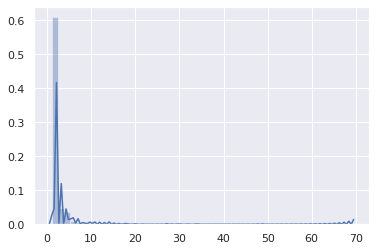

In [13]:
sns.distplot(train.groupby('Author').size().sort_values()[1500:])

In [14]:
len(set(test['Author']) - set(train['Author']))

693

> Not a good sign. Won't use authors name for prediction

In [15]:
train.groupby('Author')['Price'].describe().reset_index().sort_values('count')

,Author,count,mean,std,min,25%,50%,75%,max
0,"0, Butterfield, Ngondi, Kerr",1.0,400.000000,NaN,400.0,400.0,400.00,400.00,400.0
2283,Murugesan Ramaswamy,1.0,607.000000,NaN,607.0,607.0,607.00,607.00,607.0
2284,My Little Pony,1.0,488.000000,NaN,488.0,488.0,488.00,488.00,488.0
2285,Myatt Murphy,1.0,1109.000000,NaN,1109.0,1109.0,1109.00,1109.00,1109.0
2286,Myrna Bell Rochester,1.0,1108.000000,NaN,1108.0,1108.0,1108.00,1108.00,1108.0
...,...,...,...,...,...,...,...,...,...
1294,Herge,34.0,451.389706,171.889182,304.0,316.5,399.00,464.25,799.0
100,Albert Uderzo,34.0,388.147059,96.797236,296.0,354.0,355.00,398.75,678.0
697,DK,48.0,692.149792,314.820692,199.0,424.5,683.24,864.00,1430.0
1868,Ladybird,49.0,102.796531,68.635946,51.0,61.0,91.00,117.00,517.0


## Edition Analysis

In [16]:
train['Edition_Type'] = train['Edition'].apply(lambda x : re.findall('(.*),–.*',x)[0])
train.groupby('Edition_Type')['Price'].describe().sort_values('count')

,count,mean,std,min,25%,50%,75%,max
Edition_Type,,,,,,,,
"(French),Paperback",1.0,657.000000,NaN,657.00,657.0000,657.00,657.00,657.00
Product Bundle,1.0,14100.000000,NaN,14100.00,14100.0000,14100.00,14100.00,14100.00
Plastic Comb,1.0,1453.000000,NaN,1453.00,1453.0000,1453.00,1453.00,1453.00
Perfect Paperback,1.0,311.000000,NaN,311.00,311.0000,311.00,311.00,311.00
Leather Bound,1.0,1819.000000,NaN,1819.00,1819.0000,1819.00,1819.00,1819.00
Library Binding,1.0,296.000000,NaN,296.00,296.0000,296.00,296.00,296.00
Board book,1.0,452.690000,NaN,452.69,452.6900,452.69,452.69,452.69
"(Spanish),Paperback",1.0,295.000000,NaN,295.00,295.0000,295.00,295.00,295.00
"(Kannada),Paperback",1.0,93.000000,NaN,93.00,93.0000,93.00,93.00,93.00


In [17]:
test['Edition_Type'] = test['Edition'].apply(lambda x : re.findall('(.*),–.*',x)[0])
test.groupby('Edition_Type').size()

Edition_Type
(Chinese),Paperback         1
Cards                       1
Flexibound                  4
Hardcover                 233
Loose Leaf                  1
Mass Market Paperback      45
Paperback                1265
Sheet music                 8
Spiral-bound                2
dtype: int64

In [18]:
set(test['Edition_Type']) - set(train['Edition_Type'])

{'(Chinese),Paperback'}

> (Language), Paperback should all be grouped into one

In [0]:
train['Edition_Refine_Type'] = ['Paperback'  if re.match('\(.*\),(Paperback)',s) else s for s in train['Edition_Type']]
test['Edition_Refine_Type'] = ['Paperback'  if re.match('\(.*\),(Paperback)',s) else s for s in test['Edition_Type']]

In [20]:
set(test['Edition_Refine_Type']) - set(train['Edition_Refine_Type'])

set()

In [21]:
train.groupby('Edition_Refine_Type')['Price'].describe().sort_values('count',ascending = False)

,count,mean,std,min,25%,50%,75%,max
Edition_Refine_Type,,,,,,,,
Paperback,5197.0,495.272721,530.826557,25.00,239.0000,354.00,550.00,9984.00
Hardcover,823.0,983.294168,1170.782001,51.00,385.0000,569.00,1109.00,13244.67
Mass Market Paperback,155.0,343.352452,203.491171,37.00,248.0000,319.00,399.00,1919.00
Sheet music,24.0,799.208333,304.515293,472.00,567.0000,657.00,1056.75,1431.00
Flexibound,15.0,713.344000,433.772450,194.00,385.9550,712.00,954.50,1669.00
Cards,8.0,721.983750,413.824624,100.00,529.2175,713.00,1105.00,1191.00
Spiral-bound,4.0,1021.500000,678.792310,469.00,480.2500,869.50,1410.75,1878.00
Tankobon Softcover,3.0,610.333333,212.486078,445.00,490.5000,536.00,693.00,850.00
Loose Leaf,2.0,362.000000,60.811183,319.00,340.5000,362.00,383.50,405.00


In [22]:
available_editions = train['Edition_Refine_Type'].unique()
available_editions

array(['Paperback', 'Hardcover', 'Mass Market Paperback', 'Sheet music',
       'Flexibound', 'Plastic Comb', 'Loose Leaf', 'Tankobon Softcover',
       'Perfect Paperback', 'Board book', 'Cards', 'Spiral-bound',
       'Product Bundle', 'Library Binding', 'Leather Bound'], dtype=object)

In [23]:
considerable_editions = ['Paperback', 'Hardcover', 'Mass Market Paperback', 'Sheet music', 'Flexibound'] #based on frequency
others = [edition for edition in available_editions if edition not in considerable_editions]
train['Edition_Type_Blind_Group'] = train['Edition_Refine_Type'].replace(others,value='Others')
test['Edition_Type_Blind_Group'] = test['Edition_Refine_Type'].replace(others,value='Others')
train.groupby('Edition_Type_Blind_Group')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Edition_Type_Blind_Group,,,,,,,,
Flexibound,15.0,713.344000,433.772450,194.0,385.955,712.0,954.50,1669.00
Hardcover,823.0,983.294168,1170.782001,51.0,385.000,569.0,1109.00,13244.67
Mass Market Paperback,155.0,343.352452,203.491171,37.0,248.000,319.0,399.00,1919.00
Others,23.0,1341.241739,2825.552496,100.0,425.000,639.0,1155.50,14100.00
Paperback,5197.0,495.272721,530.826557,25.0,239.000,354.0,550.00,9984.00
Sheet music,24.0,799.208333,304.515293,472.0,567.000,657.0,1056.75,1431.00


In [24]:
set(test['Edition_Type_Blind_Group']) ^ set(train['Edition_Type_Blind_Group'])

set()

In [0]:
from random import random

In [0]:
mts = ['Oct', 'Sep', 'May', 'Jan', 'Jun', 'Nov', 'Apr', 'Jul', 'Mar', 'Aug', 'Feb', 'Dec']

In [0]:
def date_extractor(x):
  try:
    return x.split(' ')[-3] if re.match('\d+',x.split(' ')[-3]) else 'Unknown_date'
  except: 
    return 'Unknown_date'

train['Date'] = train['Edition'].apply(date_extractor)
test['Date'] = test['Edition'].apply(date_extractor)

In [0]:
train['Month'] = train['Edition'].apply(lambda x: x[-8:-5] if x[-8:-5] in mts else 'Unknown')
test['Month'] =test['Edition'].apply(lambda x: x[-8:-5] if x[-8:-5] in mts else 'Unknown')

In [0]:
train['Year'] = train['Edition'].apply(lambda x : x[-4:] if re.match('\d\d\d\d',x[-4:])\
                                                 else -1).astype('int')
test['Year'] = test['Edition'].apply(lambda x : x[-4:] if re.match('\d\d\d\d',x[-4:])\
                                                 else -1).astype('int')                                                 

In [0]:
org_train_date_idx = [i for i,date in enumerate(train['Year'])  if date!=-1]
org_test_date_idx = [i for i,date in enumerate(test['Year'])  if date!=-1]

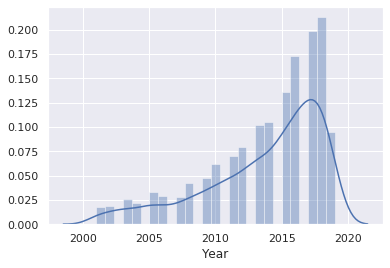

In [51]:
sns.distplot(train[train['Year']>2000]['Year'])

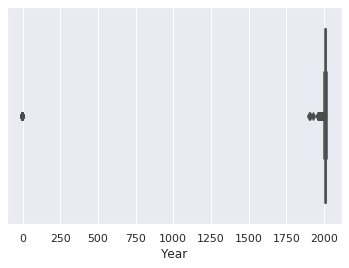

In [52]:
sns.boxplot(train['Year'])

In [0]:
train_date_median = train['Year'][org_train_date_idx].median()
test_date_median = test['Year'][org_test_date_idx].median()

In [0]:
train['Year'] = train['Year'].apply(lambda x: x if x!=-1 else train_date_median)
test['Year'] = test['Year'].apply(lambda x: x if x!=-1 else test_date_median)

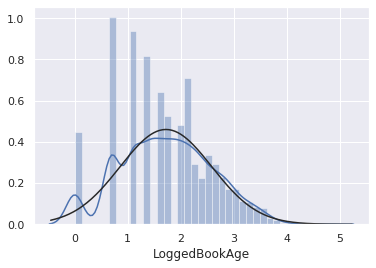

In [55]:
train['BookAge'] = 2019 - train['Year']
train['LoggedBookAge'] = np.log1p(train['BookAge'])
test['BookAge'] = 2019 - test['Year']
test['LoggedBookAge'] = np.log1p(test['BookAge'])
sns.distplot(train['LoggedBookAge'], fit=norm)

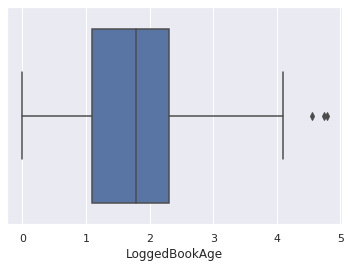

In [56]:
sns.boxplot(train['LoggedBookAge'])

In [57]:
train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Title0,Title1,Title2,Edition_Type,Edition_Refine_Type,Edition_Type_Blind_Group,Date,Month,Year,BookAge,LoggedBookAge
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,0.235165,-0.013440,0.152082,Paperback,Paperback,Paperback,10,Mar,2016.0,3.0,1.386294
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,0.090840,-0.146708,-0.136062,Paperback,Paperback,Paperback,7,Nov,2012.0,7.0,2.079442
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00,0.137015,-0.294545,0.523090,Paperback,Paperback,Paperback,25,Feb,1982.0,37.0,3.637586
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,0.095823,-0.136237,0.068786,Paperback,Paperback,Paperback,5,Oct,2017.0,2.0,1.098612
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,0.058984,-0.038359,-0.041727,Hardcover,Hardcover,Hardcover,10,Oct,2006.0,13.0,2.639057


In [0]:
import calendar
abbr_to_num = {name: num for num, name in enumerate(calendar.month_abbr) if num}

In [84]:
import datetime
a =0 
def wk_calculator(x):
  global a
  if (x['Date'] in map(str,list(range(1,32)))) and (x['Year']!=-1) and (x['Month'] in mts):
    return pd.Series(datetime.date(int(x['Year']), abbr_to_num[x['Month']], int(x['Date'])).isocalendar()[1:])
    a+=0
  else:
    # print(x)
    return pd.Series(['Unknown_yr_wk','Unknown_wk_day'])
    a+=1
train[['Yr_wk','Wk_day']] = train[['Date','Month','Year']].apply(wk_calculator, axis =1)
test[['Yr_wk','Wk_day']] = test[['Date','Month','Year']].apply(wk_calculator, axis =1)
train.head()
# for i,val in train.iterrows():
#   wk_calculator(val[['Date','Month','Year']])
print(a)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Title0,Title1,Title2,Edition_Type,Edition_Refine_Type,Edition_Type_Blind_Group,Date,Month,Year,BookAge,LoggedBookAge,Yr_wk,Wk_day
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,0.235165,-0.013440,0.152082,Paperback,Paperback,Paperback,10,Mar,2016.0,3.0,1.386294,10,4
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,0.090840,-0.146708,-0.136062,Paperback,Paperback,Paperback,7,Nov,2012.0,7.0,2.079442,45,3
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00,0.137015,-0.294545,0.523090,Paperback,Paperback,Paperback,25,Feb,1982.0,37.0,3.637586,8,4
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,0.095823,-0.136237,0.068786,Paperback,Paperback,Paperback,5,Oct,2017.0,2.0,1.098612,40,4
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,0.058984,-0.038359,-0.041727,Hardcover,Hardcover,Hardcover,10,Oct,2006.0,13.0,2.639057,41,2


0


In [85]:
train['Wk_day'].unique()
train['Yr_wk'].unique()

array([4, 3, 2, 5, 'Unknown_wk_day', 6, 7, 1], dtype=object)

array([10, 45, 8, 40, 41, 19, 9, 51, 13, 3, 24, 26, 46, 35, 44, 1,
       'Unknown_yr_wk', 47, 27, 42, 38, 16, 30, 36, 48, 39, 34, 28, 52, 2,
       23, 12, 17, 37, 4, 29, 11, 22, 20, 18, 31, 15, 5, 7, 53, 43, 25, 6,
       14, 32, 49, 33, 50, 21], dtype=object)

In [0]:
# def split(a, n):
#     k, m = divmod(len(a), n)
#     return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

# date_separators = list(split(sorted(train['Year'].unique()), 3))
# # date_replace = {date_separators[0]:'old',tuple(date_separators[1]):'medium',tuple(date_separators[2]):'recent'}
# train['Date_Binned'] = train['Year'].replace(date_separators[0],'old').replace(date_separators[1],'medium').replace(date_separators[2],'recent')
# train.head()

In [0]:
# train['Date_Binned'], bins = pd.cut(train['Year'], bins = 3,retbins= True, labels = ['Old', 'Medieval',' Recent'])

In [0]:
# test['Date_Binned'] = pd.cut(test['Year'], bins = bins, labels = ['Old', 'Medieval',' Recent'])

## Review Analysis

In [0]:
train[['Stars_Obtained','Total_Stars']] = train['Reviews'].apply(lambda x: pd.Series(re.findall('(\d.\d) out of (\d) stars',x)[0])) 
test[['Stars_Obtained','Total_Stars']] = test['Reviews'].apply(lambda x: pd.Series(re.findall('(\d.\d) out of (\d) stars',x)[0])) 

In [87]:
train.groupby('Total_Stars').size()

Total_Stars
5    6237
dtype: int64

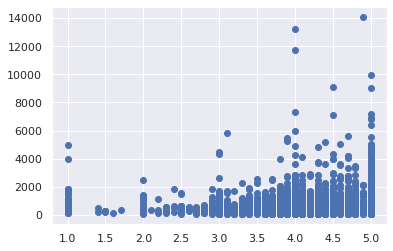

In [88]:
# train.drop('Total_Stars',axis =1 , inplace =True) #All are out of 5
train['Stars_Obtained'] =train['Stars_Obtained'].astype('float')
test['Stars_Obtained'] =test['Stars_Obtained'].astype('float')
plt.scatter(train['Stars_Obtained'],train['Price'])

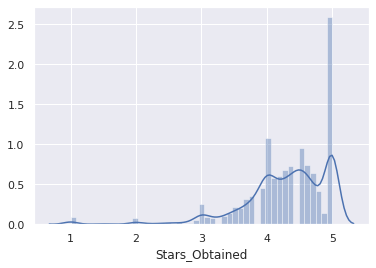

In [89]:
sns.distplot(train['Stars_Obtained'])

## Rating Analysis

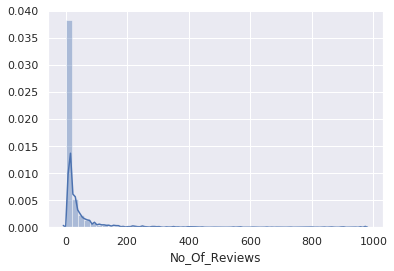

In [90]:
train['No_Of_Reviews'] = train['Ratings'].apply(lambda x: re.findall('(\d+) customer reviews?',x)[0]).astype('int')
test['No_Of_Reviews'] = test['Ratings'].apply(lambda x: re.findall('(\d+) customer reviews?',x)[0]) .astype('int')
sns.distplot(train['No_Of_Reviews'])

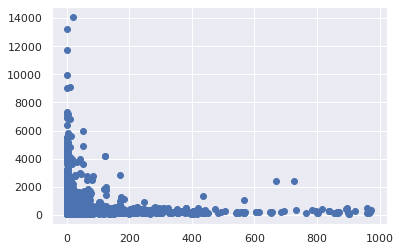

In [91]:
plt.scatter(train['No_Of_Reviews'],train['Price'])

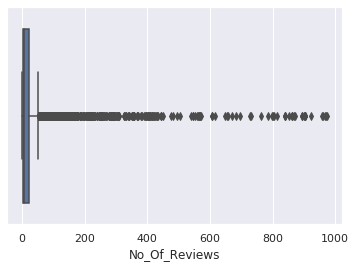

In [92]:
sns.boxplot(train['No_Of_Reviews'])

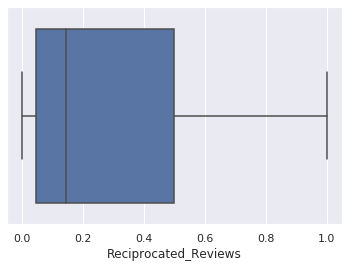

In [93]:
train['Reciprocated_Reviews'] = 1/train['No_Of_Reviews']
test['Reciprocated_Reviews'] = 1/test['No_Of_Reviews']
sns.boxplot(train['Reciprocated_Reviews'])

In [0]:
# train['Logged_Reviews'] = np.log1p(train['No_Of_Reviews'])
# test['Logged_Reviews'] = np.log1p(test['No_Of_Reviews'])
# sns.boxplot(train['Logged_Reviews'])

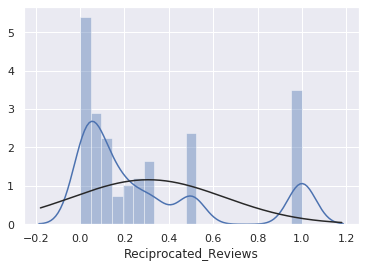

In [94]:
sns.distplot(train['Reciprocated_Reviews'], fit = norm)

## Genre Analysis

In [95]:
##Set operation 
# & : Intersection
# | : Union
# - : Difference
# ^ : Symmetric Difference

len(set(test['Genre']) - set(train["Genre"]))

18

In [0]:
#  !python -m spacy download en_core_web_lg

In [0]:
# import spacy
# # Load the spacy model that you have installed
# nlp = spacy.load('en')
# # process a sentence using the model
# genre_vector  = np.array([nlp(genre).vector for genre in train['Genre']])
# genre_vector.shape
# # It's that simple - all of the vectors and words are assigned after this point
# # Get the vector for 'text'
# # doc.shape


# genre_components = 15
# ts2= TruncatedSVD(n_components = genre_components)
# genre_features = ts2.fit_transform(genre_vector)

# genre_cols = ['Genre'+str(i) for i in range(genre_components)]
# # genre_cols

# train[genre_cols] = pd.DataFrame(genre_features)
# train[genre_cols].head()

# test_genre_vector = np.array([nlp(genre).vector for genre in test['Genre']])
# test_genre_vector.shape

# test_genre_features = ts2.transform(test_genre_vector)

# # genre_cols

# test[genre_cols] = pd.DataFrame(test_genre_features)
# test[genre_cols].head()

In [0]:
tfidf2 = TfidfVectorizer(strip_accents='unicode',lowercase=True,ngram_range=(1,2),max_df=0.7,min_df=5,tokenizer = custom_tokenizer) 

genre_sparse_matrix = tfidf2.fit_transform(train['Genre'])

ts2= TruncatedSVD(n_components = 15)
genre_features = ts2.fit_transform(genre_sparse_matrix)

genre_cols = ['Genre'+str(i) for i in range(15)]
# genre_cols

train[genre_cols] = pd.DataFrame(genre_features)

train.head()

# tfidf = TfidfVectorizer(strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.7,min_df=5,tokenizer = custom_tokenizer) 
test_genre_sparse_matrix = tfidf2.transform(test['Genre'])

# ts= TruncatedSVD(n_components = 50)
test_genre_features = ts2.transform(test_genre_sparse_matrix)

test[genre_cols] = pd.DataFrame(test_genre_features)

test.head()

## BookCategory Analysis

In [97]:
train.groupby('BookCategory').size()

len(set(test['BookCategory']) ^ set(train["BookCategory"]))

train.groupby('BookCategory')['Price'].describe()

BookCategory
Action & Adventure                      818
Arts, Film & Photography                517
Biographies, Diaries & True Accounts    596
Comics & Mangas                         583
Computing, Internet & Digital Media     510
Crime, Thriller & Mystery               723
Humour                                  540
Language, Linguistics & Writing         594
Politics                                325
Romance                                 560
Sports                                  471
dtype: int64

0

,count,mean,std,min,25%,50%,75%,max
BookCategory,,,,,,,,
Action & Adventure,818.0,415.810905,410.688382,50.00,247.000,323.76,435.00,5600.00
"Arts, Film & Photography",517.0,833.266151,927.015676,25.00,363.000,582.00,1029.00,11715.12
"Biographies, Diaries & True Accounts",596.0,345.142701,197.064828,25.00,226.750,318.00,406.25,2742.00
Comics & Mangas,583.0,752.331235,1025.436632,56.00,327.500,487.00,799.00,14100.00
"Computing, Internet & Digital Media",510.0,967.078922,938.268726,79.00,375.750,599.00,1200.00,5811.00
"Crime, Thriller & Mystery",723.0,337.337593,276.701023,68.00,206.000,280.00,369.00,2742.00
Humour,540.0,654.300574,604.206257,68.00,314.000,458.00,799.00,4999.00
"Language, Linguistics & Writing",594.0,462.115859,547.715866,30.00,175.000,316.90,520.75,5177.66
Politics,325.0,519.794123,794.656895,45.00,295.000,402.00,559.00,13244.67


## Synopsis Analysis

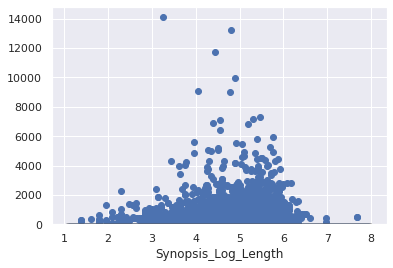

In [98]:
train['Synopsis_Log_Length']= train['Synopsis'].apply(lambda x: np.log1p(len(x.split())))
test['Synopsis_Log_Length']= test['Synopsis'].apply(lambda x: np.log1p(len(x.split())))
plt.scatter(train['Synopsis_Log_Length'], train['Price'])

sns.distplot(train['Synopsis_Log_Length'],fit =norm)

In [0]:
# # process a sentence using the model
# synopsis_vector  = np.array([nlp(synopsis).vector for synopsis in train['Synopsis']])
# synopsis_vector.shape
# # It's that simple - all of the vectors and words are assigned after this point
# # Get the vector for 'text'
# # doc.shape

# synopsis_components = 50
# ts= TruncatedSVD(n_components = synopsis_components)
# synopsis_features = ts.fit_transform(synopsis_vector)

# # synopsis_features = synopsis_vector

# synopsis_cols = ['Synopsis'+str(i) for i in range(synopsis_components)]
# # synopsis_cols

# train[synopsis_cols] = pd.DataFrame(synopsis_features)
# train[synopsis_cols].head()

# test_synopsis_vector = np.array([nlp(synopsis).vector for synopsis in test['Synopsis']])
# test_synopsis_vector.shape

# test_synopsis_features = ts.transform(test_synopsis_vector)

# # test_synopsis_features = test_synopsis_vector

# # synopsis_cols

# test[synopsis_cols] = pd.DataFrame(test_synopsis_features)
# test[synopsis_cols].head()

In [0]:
tfidf = TfidfVectorizer(strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.7,min_df=5,tokenizer = custom_tokenizer) 

text_sparse_matrix = tfidf.fit_transform(train['Synopsis'])

ts= TruncatedSVD(n_components = 50)
text_features = ts.fit_transform(text_sparse_matrix)

synopsis_cols = ['Synopsis'+str(i) for i in range(50)]
# synopsis_cols

train[synopsis_cols] = pd.DataFrame(text_features)

# train.head()

# tfidf = TfidfVectorizer(strip_accents='unicode',lowercase=True,ngram_range=(1,3),max_df=0.7,min_df=5,tokenizer = custom_tokenizer) 
test_text_sparse_matrix = tfidf.transform(test['Synopsis'])

# ts= TruncatedSVD(n_components = 50)
test_text_features = ts.transform(test_text_sparse_matrix)

test[synopsis_cols] = pd.DataFrame(test_text_features)

# test.head()

## Price Analysis

In [0]:
sns.distplot(train['Price'])

train['Logged_Price'] = np.log1p(train['Price'])
sns.distplot(train['Logged_Price'],fit =norm)

sns.boxplot(train['Logged_Price'])

## Feature Selection

In [101]:
train.columns

Index(['Title', 'Author', 'Edition', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
       'BookCategory', 'Price', 'Title0', 'Title1', 'Title2', 'Edition_Type',
       'Edition_Refine_Type', 'Edition_Type_Blind_Group', 'Date', 'Month',
       'Year', 'BookAge', 'LoggedBookAge', 'Yr_wk', 'Wk_day', 'Stars_Obtained',
       'Total_Stars', 'No_Of_Reviews', 'Reciprocated_Reviews', 'Genre0',
       'Genre1', 'Genre2', 'Genre3', 'Genre4', 'Genre5', 'Genre6', 'Genre7',
       'Genre8', 'Genre9', 'Genre10', 'Genre11', 'Genre12', 'Genre13',
       'Genre14', 'Synopsis_Log_Length', 'Synopsis0', 'Synopsis1', 'Synopsis2',
       'Synopsis3', 'Synopsis4', 'Synopsis5', 'Synopsis6', 'Synopsis7',
       'Synopsis8', 'Synopsis9', 'Synopsis10', 'Synopsis11', 'Synopsis12',
       'Synopsis13', 'Synopsis14', 'Synopsis15', 'Synopsis16', 'Synopsis17',
       'Synopsis18', 'Synopsis19', 'Synopsis20', 'Synopsis21', 'Synopsis22',
       'Synopsis23', 'Synopsis24', 'Synopsis25', 'Synopsis26', 'Synopsis27',
       '

In [0]:
train.info()

In [176]:
selected_nums = ['Stars_Obtained','Reciprocated_Reviews','Synopsis_Log_Length','LoggedBookAge']\
+[col for col in train.columns if re.match('Synopsis\d+',col)]\
+[col for col in train.columns if re.match('Genre\d+',col)]\
+[col for col in train.columns if re.match('Title\d+',col)]
selected_cats = ['Edition_Type_Blind_Group','BookCategory','Month','Wk_day','Yr_wk']
target = 'Logged_Price'

from copy import deepcopy

train_X = deepcopy(train[selected_nums+selected_cats])
train_Y = deepcopy(train[target])
train_X.head()
train_Y.head()

test_X = deepcopy(test[selected_nums+selected_cats])
test_X.head()

,Stars_Obtained,Reciprocated_Reviews,Synopsis_Log_Length,LoggedBookAge,Synopsis0,Synopsis1,Synopsis2,Synopsis3,Synopsis4,Synopsis5,Synopsis6,Synopsis7,Synopsis8,Synopsis9,Synopsis10,Synopsis11,Synopsis12,Synopsis13,Synopsis14,Synopsis15,Synopsis16,Synopsis17,Synopsis18,Synopsis19,Synopsis20,Synopsis21,Synopsis22,Synopsis23,Synopsis24,Synopsis25,Synopsis26,Synopsis27,Synopsis28,Synopsis29,Synopsis30,Synopsis31,Synopsis32,Synopsis33,Synopsis34,Synopsis35,Synopsis36,Synopsis37,Synopsis38,Synopsis39,Synopsis40,Synopsis41,Synopsis42,Synopsis43,Synopsis44,Synopsis45,Synopsis46,Synopsis47,Synopsis48,Synopsis49,Genre0,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9,Genre10,Genre11,Genre12,Genre13,Genre14,Title0,Title1,Title2,Edition_Type_Blind_Group,BookCategory,Month,Wk_day,Yr_wk
0,4.0,0.125000,4.882802,1.386294,0.195728,0.026844,0.007001,0.104842,-0.115959,-0.062463,0.058581,0.037248,-0.059300,-0.002390,0.007564,-0.009537,0.005031,-0.031585,-0.038181,0.036874,0.070726,0.006902,0.016061,-0.000678,-0.001276,-0.000364,-0.033591,0.007107,-0.008667,-0.009717,0.021491,-0.030230,-0.019747,0.010846,-0.005396,0.015353,-0.000914,-0.010748,0.004818,-0.012644,0.001930,-0.013389,0.008368,0.024993,-0.005468,-0.036328,0.042573,-0.005339,0.004673,0.019330,-0.009505,0.013170,-0.022560,-0.022291,0.998997,-6.727814e-08,-0.038418,-0.018991,-0.003358,-0.000007,0.006748,-0.000050,-0.000293,-0.000523,-0.004507,-0.004783,0.000187,-0.004423,-0.000991,0.235165,-0.013440,0.152082,Paperback,Action & Adventure,Mar,4,10
1,3.9,0.071429,5.214936,2.079442,0.137068,-0.021024,0.022704,-0.026618,0.009403,-0.014302,0.016929,0.002849,0.025142,0.001821,0.025864,0.024367,0.021973,0.005079,0.005833,-0.012076,-0.001595,-0.019274,0.035075,-0.030693,-0.028717,-0.000369,0.052015,-0.028043,0.019385,0.021374,0.007555,-0.008808,-0.021651,-0.023953,-0.029225,0.003102,0.019572,0.012602,0.013453,0.011094,0.028258,0.021017,-0.004178,0.002807,-0.007556,0.006423,-0.026566,-0.041613,0.002217,0.058564,-0.054210,0.002241,-0.009871,0.008144,0.040665,3.879475e-06,0.036317,0.030994,0.005867,-0.000024,-0.049146,0.000601,0.005406,-0.001161,0.089773,0.182155,-0.035977,0.756379,-0.568957,0.090840,-0.146708,-0.136062,Paperback,"Biographies, Diaries & True Accounts",Nov,3,45
2,4.8,0.166667,5.533389,3.637586,0.195584,-0.042575,-0.013691,-0.167104,0.256708,0.142375,0.488720,0.063148,-0.215493,-0.025303,-0.068699,-0.076544,0.020127,-0.013725,0.042456,0.006272,0.029724,0.017028,-0.015244,0.014623,0.015266,-0.004439,-0.019018,-0.005771,-0.011510,-0.019449,-0.008993,0.001283,0.007664,0.040442,0.002467,-0.016952,0.008800,0.025507,-0.023484,0.003952,-0.017977,-0.003477,0.004355,0.002094,0.017647,-0.003144,-0.000083,0.015276,-0.038032,0.007991,-0.022470,-0.010220,-0.024468,-0.012779,0.000154,1.296949e-07,0.000319,0.000346,0.000067,-0.000005,-0.000805,-0.000091,-0.000111,0.000296,0.001837,0.002753,-0.000134,0.003694,0.001494,0.137015,-0.294545,0.523090,Paperback,Humour,Feb,4,8
3,4.1,0.076923,4.330733,1.098612,0.111477,0.019501,-0.069359,0.008105,0.026872,0.009353,-0.011334,0.016059,-0.010393,-0.002564,-0.005609,0.063142,-0.019788,-0.012248,-0.001450,-0.056748,0.047622,0.020781,0.029130,-0.009201,-0.000657,-0.029546,-0.057012,-0.008354,0.027760,-0.013552,-0.036933,-0.021485,-0.038657,-0.005837,0.021760,0.003918,-0.003522,-0.022421,0.043085,0.025266,-0.000680,0.005305,-0.009507,0.020964,0.031715,-0.000992,0.006176,0.032240,-0.013860,-0.014472,-0.008616,-0.030332,-0.024853,0.027016,0.000254,-6.657987e-07,0.001387,0.015182,-0.009403,0.996985,0.000790,-0.000069,-0.000939,0.000443,-0.001393,-0.002302,-0.001104,0.001236,-0.001270,0.095823,-0.136237,0.068786,Paperback,"Crime, Thriller & Mystery",Oct,4,40
4,5.0,1.000000,4.653960,2.639057,0.143512,-0.015590,-0.036500,-0.063889,0.029277,0.028097,0.002893,0.000756,-0.020623,0.053423,0.146450,-0.084637,0.053218,0.078815,0.011452,-0.009923,-0.016307,0.008049,-0.050479,-0.006335,0.031217,0.005133,-0.041644,0.017695,-0.016641,-0.006916,-0.000166,0.026878,-0.

0    5.398163
1    5.317777
2    5.703782
3    5.198497
4    6.873805
Name: Logged_Price, dtype: float64

,Stars_Obtained,Reciprocated_Reviews,Synopsis_Log_Length,LoggedBookAge,Synopsis0,Synopsis1,Synopsis2,Synopsis3,Synopsis4,Synopsis5,Synopsis6,Synopsis7,Synopsis8,Synopsis9,Synopsis10,Synopsis11,Synopsis12,Synopsis13,Synopsis14,Synopsis15,Synopsis16,Synopsis17,Synopsis18,Synopsis19,Synopsis20,Synopsis21,Synopsis22,Synopsis23,Synopsis24,Synopsis25,Synopsis26,Synopsis27,Synopsis28,Synopsis29,Synopsis30,Synopsis31,Synopsis32,Synopsis33,Synopsis34,Synopsis35,Synopsis36,Synopsis37,Synopsis38,Synopsis39,Synopsis40,Synopsis41,Synopsis42,Synopsis43,Synopsis44,Synopsis45,Synopsis46,Synopsis47,Synopsis48,Synopsis49,Genre0,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9,Genre10,Genre11,Genre12,Genre13,Genre14,Title0,Title1,Title2,Edition_Type_Blind_Group,BookCategory,Month,Wk_day,Yr_wk
0,4.4,0.001042,5.780744,3.526361,0.173248,-0.003959,0.009878,0.028614,0.018477,-0.054828,0.054642,-0.033618,0.024265,0.008862,0.031593,0.016228,-0.002073,0.023302,-0.031526,-0.032727,0.000488,-0.039509,0.042820,0.028764,-0.039965,0.034648,-0.000527,-0.009444,-0.011999,0.011364,0.028899,-0.052614,-0.053064,-0.061653,-0.017008,0.006951,0.006905,-0.006929,0.136329,0.002501,0.069976,-0.024541,0.024263,0.016988,0.034876,0.038896,-0.035753,0.019317,-0.067536,0.011228,0.046452,-0.008833,-0.029174,-0.013735,3.714592e-05,4.351081e-07,7.674135e-05,1.227666e-04,-1.172544e-05,7.524321e-05,2.688339e-04,6.881555e-04,4.255084e-03,-3.504568e-03,-1.891496e-03,3.234608e-03,2.951026e-03,-9.461812e-03,9.807491e-03,0.116129,0.000221,-0.014425,Mass Market Paperback,"Crime, Thriller & Mystery",Oct,3,40
1,5.0,1.000000,5.746203,0.693147,0.128074,-0.035010,0.086144,-0.037881,0.005622,0.051839,-0.056607,-0.019429,-0.011180,-0.014321,-0.053344,-0.038494,-0.014116,-0.066281,-0.033802,-0.053054,-0.010377,0.019950,-0.033710,0.062487,-0.008221,0.005539,0.008123,0.006765,0.016894,-0.013738,0.001215,0.051618,0.001161,-0.021064,-0.004822,-0.010215,-0.027320,0.010149,0.018204,0.016938,-0.003657,0.016788,0.006116,0.013244,-0.019031,0.012070,0.027862,0.034795,0.039997,0.004676,-0.038618,-0.005931,-0.017829,-0.044136,2.149352e-04,-1.846493e-07,4.497282e-04,4.959952e-04,9.072693e-05,-1.317696e-06,-1.851638e-03,5.733917e-03,2.150535e-03,1.471663e-03,5.927717e-03,2.362521e-03,1.827966e-03,5.093698e-03,-6.280712e-03,0.114429,-0.160910,-0.155522,Paperback,"Computing, Internet & Digital Media",Apr,4,17
2,5.0,0.250000,5.153292,2.197225,0.185156,0.027251,-0.066209,0.046131,-0.060333,-0.022958,-0.016550,0.048035,-0.042003,-0.013930,-0.047335,-0.016155,0.004606,0.009344,-0.000701,0.014118,-0.028044,-0.016985,-0.009084,-0.012225,-0.009042,-0.013222,-0.002266,-0.011131,0.015446,0.005817,0.002296,0.046148,-0.011610,-0.011462,0.015637,-0.006524,0.010199,0.034821,-0.028977,-0.006685,-0.010485,-0.005044,0.007688,-0.004504,-0.010146,-0.001393,-0.010628,-0.006568,0.011856,-0.004337,-0.004256,-0.003659,-0.011432,-0.003380,-6.008894e-13,1.000000e+00,-9.519135e-10,8.054611e-11,-1.831636e-09,-1.324235e-09,4.181765e-08,6.853198e-09,4.457925e-08,-1.410732e-07,-4.500826e-08,1.036034e-07,-6.163154e-08,-2.624838e-07,1.854012e-07,0.017554,-0.012719,-0.006462,Paperback,Romance,Mar,4,11
3,4.1,0.090909,5.204007,1.386294,0.165480,-0.052417,0.192465,-0.012299,-0.049099,0.064448,-0.051817,0.021856,-0.068528,-0.011340,-0.057016,-0.033483,-0.051723,-0.085456,-0.062379,-0.067877,-0.017213,0.064855,0.003700,0.049256,0.000044,0.013500,-0.025998,0.013838,0.060670,-0.013697,0.013914,0.069899,0.030281,-0.001523,-0.001309,0.024676,-0.025950,-0.007744,0.044725,0.028153,0.055837,-0.014274,-0.038990,-0.009971,-0.008614,-0.002674,-0.015596,-0.025739,-0.014679,-0.017978,0.016029,0.038827,0.002520,-0.013964,3.058791e-02,3.319856e-07,2.563284e-02,2.104778e-02,3.934193e-03,-1.032199e-05,-2.657126e-02,-9.548187e-05,1.740426e-03,2.175449e-02,4.396736e-02,3.874620e-02,-6.131632e-03,7.190024e-02,4.965870e-02,0.059469,-0.094968,-0.100692,Paperback,"Computing, Internet & Digital Media",Unknown,Unknown_wk_day,Unknown_yr_wk
4,4.4,0.111111,

In [0]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train_X_scaled = pd.DataFrame(ss.fit_transform(train_X[selected_nums]), columns = selected_nums).join(train_X[selected_cats])
train_X_scaled.head()

test_X_scaled = pd.DataFrame(ss.transform(test_X[selected_nums]), columns = selected_nums).join(test_X[selected_cats])
test_X_scaled.head()

train_X_scaled.shape

test_X_scaled.shape

train_X_encoded_ = pd.get_dummies(train_X_scaled, columns = selected_cats)
test_X_encoded_ = pd.get_dummies(test_X_scaled, columns = selected_cats)
# # Get missing columns in the training test
# missing_cols_test = set( train_X_encoded_.columns ) - set( test_X_encoded.columns )
# missing_cols_train = set(test_X_encoded.columns) - set(train_X_encoded_.columns)
# # Add a missing column in test set with default value equal to 0
# for c in missing_cols_test:
#     test_X_encoded[c] = 0

# for c in missing_cols_train:
#     train_X_encoded_[c] =  0
# # Ensure the order of column in the test set is in the same order than in train set
# test_X_encoded = test_X_encoded[train_X_encoded_.columns]
train_X_encoded_.shape
test_X_encoded_.shape
# assert set( train_X_encoded_.columns ) - set( test_X_encoded_.columns ) == set()

In [0]:
# log_price_mean = train['Logged_Price'].mean()
# log_price_max = train['Logged_Price'].max()
# log_price_min = train['Logged_Price'].min()

# log_price_std = train['Logged_Price'].std()
# train['Norm_Logged_Price'] = (train['Logged_Price'] - log_price_min)/(log_price_max - log_price_min)
# # train['Norm_Logged_Price']  = (train['Logged_Price']- log_price_mean)/log_price_std
# sns.distplot(train['Norm_Logged_Price'], fit = norm)

In [0]:
# price_mean = train['Price'].mean()
# price_max = train['Price'].max()
# price_min = train['Price'].min()

# price_std = train['Price'].std()
# train['Norm_Price'] = (train['Price'] - price_min)/(price_max - price_min)
# # train['Norm_Price']  = (train['Price']- price_mean)/price_std
# sns.distplot(train['Norm_Price'], fit = norm)

## Outlier Detection

In [178]:
outlier = True

from sklearn.ensemble import IsolationForest
from collections import Counter
if outlier==True:
    ilf = IsolationForest(contamination=0.05)
#     ilf.fit(train_X_encoded_)
    train_X_encoded_['Outlier'] = ilf.fit_predict(train_X_encoded_)
    test_X_encoded_['Outlier'] = ilf.fit_predict(test_X_encoded_)
#     normal_index = [i for (i,is_normal) in enumerate(outlier_preds)  if is_normal==1 ]
#     print(normal_index)

#     train_X_encoded= deepcopy(train_X_encoded_.iloc[normal_index,:])
    train_X_encoded = deepcopy(train_X_encoded_)
    test_X_encoded = deepcopy(test_X_encoded_)
#     train_Y =train_Y[normal_index]
    # train_X_encoded = train_X_encoded_[train_X_encoded_['Outlier']==1]
    # train_X_encoded_.drop('Outlier',axis = 1, inplace =True)
    train_X_encoded.shape
    test_X_encoded.shape
else:
    train_X_encoded = train_X_encoded_
    test_X_encoded = test_X_encoded_

test_X_encoded.head()

train_X_encoded.shape
train_X_encoded_.shape

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


(6237, 165)

(1560, 165)

,Stars_Obtained,Reciprocated_Reviews,Synopsis_Log_Length,LoggedBookAge,Synopsis0,Synopsis1,Synopsis2,Synopsis3,Synopsis4,Synopsis5,Synopsis6,Synopsis7,Synopsis8,Synopsis9,Synopsis10,Synopsis11,Synopsis12,Synopsis13,Synopsis14,Synopsis15,Synopsis16,Synopsis17,Synopsis18,Synopsis19,Synopsis20,Synopsis21,Synopsis22,Synopsis23,Synopsis24,Synopsis25,Synopsis26,Synopsis27,Synopsis28,Synopsis29,Synopsis30,Synopsis31,Synopsis32,Synopsis33,Synopsis34,Synopsis35,...,Yr_wk_16,Yr_wk_17,Yr_wk_18,Yr_wk_19,Yr_wk_20,Yr_wk_21,Yr_wk_22,Yr_wk_23,Yr_wk_24,Yr_wk_25,Yr_wk_26,Yr_wk_27,Yr_wk_28,Yr_wk_29,Yr_wk_30,Yr_wk_31,Yr_wk_32,Yr_wk_33,Yr_wk_34,Yr_wk_35,Yr_wk_36,Yr_wk_37,Yr_wk_38,Yr_wk_39,Yr_wk_40,Yr_wk_41,Yr_wk_42,Yr_wk_43,Yr_wk_44,Yr_wk_45,Yr_wk_46,Yr_wk_47,Yr_wk_48,Yr_wk_49,Yr_wk_50,Yr_wk_51,Yr_wk_52,Yr_wk_53,Yr_wk_Unknown_yr_wk,Outlier
0,0.161217,-0.891764,1.332930,2.080192,0.664046,-0.049558,0.128965,0.537971,0.258051,-1.018578,1.042377,-0.639798,0.466618,0.139290,0.688408,0.294938,-0.054667,0.527294,-0.684154,-0.853019,-0.008253,-0.998780,1.160093,0.742924,-1.048680,0.952548,0.008197,-0.280482,-0.344154,0.276940,0.824575,-1.500778,-1.511881,-1.781559,-0.508360,0.190204,0.238079,-0.209289,4.117393,0.061952,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.066948,2.014075,1.277486,-1.187751,-0.333334,-0.471318,1.237290,-0.525578,0.040595,0.896300,-1.004144,-0.367592,-0.236125,-0.342318,-1.132015,-0.918462,-0.325736,-1.524219,-0.738665,-1.347443,-0.280021,0.521182,-0.816442,1.626044,-0.209636,0.178116,0.243485,0.163126,0.454924,-0.422831,0.047273,1.481695,0.047947,-0.609749,-0.154648,-0.311337,-0.783823,0.301101,0.531556,0.503300,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1.066948,-0.167577,0.325733,0.547112,0.926956,0.374357,-0.976766,0.818150,-1.075072,-0.446458,-0.267263,0.926658,-0.847219,-0.334187,-1.003223,-0.423115,0.095648,0.207644,0.053965,0.286454,-0.721919,-0.423008,-0.180418,-0.330459,-0.231348,-0.321024,-0.039117,-0.326658,0.414875,0.122310,0.077618,1.325179,-0.319423,-0.332559,0.439174,-0.203515,0.336429,1.038488,-0.900709,-0.218892,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,-0.291648,-0.630351,0.407142,-0.388247,0.492538,-0.707755,2.782395,-0.116403,-0.885037,1.122645,-0.916025,0.424436,-1.373121,-0.280385,-1.210723,-0.807345,-1.172186,-1.963330,-1.422960,-1.708001,-0.451001,1.669112,0.149753,1.279582,0.008818,0.389928,-0.684670,0.356718,1.665655,-0.421696,0.403844,2.004774,0.885608,-0.045613,-0.052687,0.708097,-0.742904,-0.233671,1.336633,0.846161,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0.161217,-0.571586,-3.306745,0.547112,-2.494261,-0.238393,0.967356,0.036521,0.272255,0.209450,-0.165232,0.448031,-0.416158,-0.281428,-0.854816,0.735686,-0.231794,1.494124,0.624178,0.739665,-0.402448,0.761763,0.179259,-2.115813,0.569084,2.052203,-0.632621,-0.114063,1.300774,-0.031050,-0.112574,-0.531017,0.754104,0.301287,-1.280358,-0.384574,-0.410343,1.404256,0.674628,0.670671,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


(6237, 165)

(6237, 165)

In [0]:
set(train_X_scaled.columns) ^ set(train_X_encoded.columns)

In [180]:
train_X_scaled['Outlier'] = train_X_encoded['Outlier']
test_X_scaled['Outlier'] = test_X_encoded['Outlier']
train_X_scaled.head()
train_X_scaled.shape

,Stars_Obtained,Reciprocated_Reviews,Synopsis_Log_Length,LoggedBookAge,Synopsis0,Synopsis1,Synopsis2,Synopsis3,Synopsis4,Synopsis5,Synopsis6,Synopsis7,Synopsis8,Synopsis9,Synopsis10,Synopsis11,Synopsis12,Synopsis13,Synopsis14,Synopsis15,Synopsis16,Synopsis17,Synopsis18,Synopsis19,Synopsis20,Synopsis21,Synopsis22,Synopsis23,Synopsis24,Synopsis25,Synopsis26,Synopsis27,Synopsis28,Synopsis29,Synopsis30,Synopsis31,Synopsis32,Synopsis33,Synopsis34,Synopsis35,Synopsis36,Synopsis37,Synopsis38,Synopsis39,Synopsis40,Synopsis41,Synopsis42,Synopsis43,Synopsis44,Synopsis45,Synopsis46,Synopsis47,Synopsis48,Synopsis49,Genre0,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9,Genre10,Genre11,Genre12,Genre13,Genre14,Title0,Title1,Title2,Edition_Type_Blind_Group,BookCategory,Month,Wk_day,Yr_wk,Outlier
0,-0.442603,-0.531185,-0.108461,-0.388247,1.160383,0.368820,0.087158,1.757200,-2.016013,-1.155640,1.114840,0.719716,-1.190154,-0.094460,0.173405,-0.276366,0.105210,-0.729637,-0.843529,0.839983,1.748529,0.187650,0.468996,-0.028084,-0.026070,0.021067,-0.891195,0.172496,-0.251990,-0.310757,0.616581,-0.860282,-0.553477,0.311469,-0.171319,0.435711,0.004619,-0.323428,0.125205,-0.401063,0.054485,-0.420716,0.254622,0.798009,-0.178754,-1.167372,1.370678,-0.171856,0.160122,0.636025,-0.332618,0.436972,-0.756995,-0.777713,2.355914,-0.268363,-0.464605,-0.418506,-0.139059,-0.225928,0.098029,-0.147257,-0.151296,-0.160916,-0.344551,-0.187150,-0.109094,-0.161416,-0.038639,0.875397,0.372228,1.502171,Paperback,Action & Adventure,Mar,4,10,1
1,-0.593558,-0.687017,0.424686,0.411257,-0.134744,-0.281355,0.315351,-0.345443,0.104567,-0.291053,0.348624,0.059794,0.484002,-0.006973,0.565605,0.475405,0.486538,0.109993,0.210421,-0.350680,-0.060362,-0.481510,0.960066,-0.814110,-0.751373,0.020920,1.437422,-0.789514,0.523843,0.555979,0.225299,-0.247321,-0.608261,-0.693164,-0.862986,0.077743,0.616299,0.374416,0.387308,0.324643,0.865542,0.658080,-0.139890,0.097500,-0.245344,0.204679,-0.861045,-1.350735,0.079781,1.922770,-1.810888,0.074346,-0.332976,0.250011,-0.365978,-0.268347,-0.146161,-0.170838,-0.094414,-0.226011,-0.287304,-0.142568,-0.105980,-0.166052,0.446161,1.395709,-0.423067,6.663278,-5.214580,-0.314338,-0.869942,-1.172808,Paperback,"Biographies, Diaries & True Accounts",Nov,3,45,1
2,0.765038,-0.409982,0.935873,2.208484,1.157198,-0.574072,-0.213553,-2.592443,4.287884,2.521589,9.027630,1.216580,-4.286874,-0.570450,-1.461115,-1.762182,0.444996,-0.320648,1.087403,0.095605,0.722974,0.446503,-0.339510,0.372609,0.411151,-0.087355,-0.494787,-0.179958,-0.330621,-0.582042,-0.239343,0.041426,0.235013,1.165924,0.056913,-0.508189,0.294666,0.760113,-0.733948,0.106296,-0.558765,-0.109937,0.128422,0.074982,0.558276,-0.102366,-0.006183,0.498101,-1.236640,0.264136,-0.761333,-0.339082,-0.820781,-0.456520,-0.481039,-0.268362,-0.299546,-0.322692,-0.122481,-0.225919,0.045958,-0.147553,-0.149851,-0.154325,-0.291344,-0.123340,-0.111883,-0.088605,-0.015990,0.066303,-2.247909,4.946421,Paperback,Humour,Feb,4,8,1
3,-0.291648,-0.671035,-0.994651,-0.720071,-0.699766,0.269090,-1.022542,0.209936,0.400061,0.133587,-0.171298,0.313213,-0.220532,-0.098071,-0.108922,1.335190,-0.453405,-0.286818,0.036023,-1.437289,1.170641,0.542432,0.806517,-0.251269,-0.009728,-0.755333,-1.528279,-0.250655,0.755458,-0.417653,-1.023845,-0.610048,-1.097435,-0.170166,0.616886,0.101587,-0.073244,-0.672308,1.286826,0.757897,-0.025915,0.165441,-0.307453,0.670787,1.006853,-0.033299,0.195847,1.049445,-0.446046,-0.472565,-0.303231,-1.006358,-0.833635,0.887292,-0.480754,-0.268365,-0.294995,-0.249184,-0.168320,4.719286,0.056956,-0.147390,-0.156433,-0.153139,-0.318430,-0.166138,-0.120303,-0.110652,-0.041179,-0.273265,-0.772346,0.728899,Paperback,"Crime, Thriller & Mystery",Oct,4,40,1
4,1.066948,2.014075,-0.475802,1.056740,0.007532,-0.207545,-0.545019,-0.941566,0.440735,0.470083,0.090419,0.019644,-0.423352,1.064970,3.150089,-1.941633,1.189794,1.798594,0.344981,-0.298313,-0.428340,0.216947,-1.249529,-0.176233,0.832757,0.167305,-1

(6237, 78)

In [146]:
test_X_scaled.head()

,Stars_Obtained,Reciprocated_Reviews,Synopsis_Log_Length,LoggedBookAge,Synopsis0,Synopsis1,Synopsis2,Synopsis3,Synopsis4,Synopsis5,Synopsis6,Synopsis7,Synopsis8,Synopsis9,Synopsis10,Synopsis11,Synopsis12,Synopsis13,Synopsis14,Synopsis15,Synopsis16,Synopsis17,Synopsis18,Synopsis19,Synopsis20,Synopsis21,Synopsis22,Synopsis23,Synopsis24,Synopsis25,Synopsis26,Synopsis27,Synopsis28,Synopsis29,Synopsis30,Synopsis31,Synopsis32,Synopsis33,Synopsis34,Synopsis35,Synopsis36,Synopsis37,Synopsis38,Synopsis39,Synopsis40,Synopsis41,Synopsis42,Synopsis43,Synopsis44,Synopsis45,Synopsis46,Synopsis47,Synopsis48,Synopsis49,Genre0,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9,Genre10,Genre11,Genre12,Genre13,Genre14,Title0,Title1,Title2,Edition_Type_Blind_Group,BookCategory,Month,Wk_day,Yr_wk,Outlier
0,0.161217,-0.891764,1.332930,2.080192,0.664046,-0.049558,0.128965,0.537971,0.258051,-1.018578,1.042377,-0.639798,0.466618,0.139290,0.688408,0.294938,-0.054667,0.527294,-0.684154,-0.853019,-0.008253,-0.998780,1.160093,0.742924,-1.048680,0.952548,0.008197,-0.280482,-0.344154,0.276940,0.824575,-1.500778,-1.511881,-1.781559,-0.508360,0.190204,0.238079,-0.209289,4.117393,0.061952,2.150685,-0.770413,0.754423,0.545267,1.107664,1.246859,-1.157576,0.629453,-2.201589,0.370309,1.517721,-0.293056,-0.978033,-0.488795,-0.481370,-0.268361,-0.300579,-0.323799,-0.122864,-0.225520,0.053363,-0.141944,-0.115133,-0.184914,-0.322612,-0.119260,-0.085098,-0.206619,0.059768,-0.105871,0.499556,-0.043594,Mass Market Paperback,"Crime, Thriller & Mystery",Oct,3,40,1
1,1.066948,2.014075,1.277486,-1.187751,-0.333334,-0.471318,1.237290,-0.525578,0.040595,0.896300,-1.004144,-0.367592,-0.236125,-0.342318,-1.132015,-0.918462,-0.325736,-1.524219,-0.738665,-1.347443,-0.280021,0.521182,-0.816442,1.626044,-0.209636,0.178116,0.243485,0.163126,0.454924,-0.422831,0.047273,1.481695,0.047947,-0.609749,-0.154648,-0.311337,-0.783823,0.301101,0.531556,0.503300,-0.117616,0.525487,0.183802,0.427046,-0.611234,0.385917,0.895825,1.132476,1.315459,0.155412,-1.295288,-0.196777,-0.598925,-1.515383,-0.480865,-0.268363,-0.298990,-0.321950,-0.122369,-0.225900,0.038745,-0.105643,-0.131868,-0.144859,-0.257034,-0.126644,-0.094848,-0.076050,-0.086846,-0.119881,-1.002324,-1.353465,Paperback,"Computing, Internet & Digital Media",Apr,4,17,1
2,1.066948,-0.167577,0.325733,0.547112,0.926956,0.374357,-0.976766,0.818150,-1.075072,-0.446458,-0.267263,0.926658,-0.847219,-0.334187,-1.003223,-0.423115,0.095648,0.207644,0.053965,0.286454,-0.721919,-0.423008,-0.180418,-0.330459,-0.231348,-0.321024,-0.039117,-0.326658,0.414875,0.122310,0.077618,1.325179,-0.319423,-0.332559,0.439174,-0.203515,0.336429,1.038488,-0.900709,-0.218892,-0.327961,-0.159075,0.233252,-0.133353,-0.327938,-0.046172,-0.346563,-0.211788,0.395042,-0.140171,-0.159033,-0.121387,-0.385130,-0.139139,-0.481476,3.726317,-0.300906,-0.324407,-0.122808,-0.225894,0.051510,-0.146895,-0.148970,-0.156706,-0.306749,-0.146647,-0.110719,-0.121745,-0.029607,-0.918463,0.378951,0.030333,Paperback,Romance,Mar,4,11,1
3,-0.291648,-0.630351,0.407142,-0.388247,0.492538,-0.707755,2.782395,-0.116403,-0.885037,1.122645,-0.916025,0.424436,-1.373121,-0.280385,-1.210723,-0.807345,-1.172186,-1.963330,-1.422960,-1.708001,-0.451001,1.669112,0.149753,1.279582,0.008818,0.389928,-0.684670,0.356718,1.665655,-0.421696,0.403844,2.004774,0.885608,-0.045613,-0.052687,0.708097,-0.742904,-0.233671,1.336633,0.846161,1.715115,-0.448482,-1.234495,-0.305948,-0.279099,-0.087275,-0.506937,-0.834849,-0.472834,-0.587553,0.511716,1.288187,0.081081,-0.496540,-0.394599,-0.268361,-0.191685,-0.220119,-0.103766,-0.225945,-0.131672,-0.147582,-0.135130,0.018402,0.061996,0.181426,-0.163953,0.523231,0.422936,-0.572943,-0.387683,-0.844452,Paperback,"Computing, Internet & Digital Media",Unknown,Unknown_wk_day,Unknown_yr_wk,1
4,0.161217,-0.571586,-3.306745,0.547112,-2.494261,-0.238393,0.967356,0.036521,0.272255,0.209450,-0.165232,0.448031,-0.416158,-0.281428,-0.854816,0.735686,-0.231794,1.494124,0.624178

In [147]:
test_X_scaled['Outlier'].value_counts()

 1    1482
-1      78
Name: Outlier, dtype: int64

In [0]:
# train_rnd_idx = np.random.permutation(train_X_encoded.shape[0])
# test_rnd_idx = np.random.permutation(test_X_encoded.shape[0])
# train_X_encoded = train_X_encoded.iloc[train_rnd_idx,:]
# train_Y = train_Y[train_rnd_idx]
# test_X_encoded = test_X_encoded.iloc[test_rnd_idx,:]

In [0]:
# train_X_encoded.head()
# train_Y

In [0]:
train_X_encoded['Outlier']= train_X_encoded['Outlier'].apply(lambda x: 0 if x==-1 else x)
test_X_encoded['Outlier']= test_X_encoded['Outlier'].apply(lambda x: 0 if x==-1 else x)

## Model Feature Selection - Couldn't finish

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
select = SelectFromModel(RandomForestRegressor(), threshold="median")

## Features Saving

In [0]:
#train_X_encoded , train_Y, test_X_encoded
train_X_encoded.to_csv('train_X_encoded.csv', index = False)
train_Y.to_csv('train_Y.csv', index = False)
test_X_encoded.to_csv('test_X_encoded.csv', index = False)

In [0]:
#train_X_scaled , train_Y, test_X_scaled

train_X_scaled.to_csv('train_X_scaled.csv', index = False)
# train_Y.to_csv('train_Y.csv', index = False)
test_X_scaled.to_csv('test_X_scaled.csv', index = False)

In [0]:
#train_X_encoded , train_Y, test_X_encoded
train_X_encoded = pd.read_csv('train_X_encoded.csv')
train_Y = pd.read_csv('train_Y.csv')
test_X_encoded = pd.read_csv('test_X_encoded.csv')

In [0]:
train_X_scaled = pd.read_csv('train_X_scaled.csv')
test_X_scaled = pd.read_csv('test_X_scaled.csv')

## Dimension Reduction - Didn't work

In [0]:
# from sklearn.decomposition import PCA
# #Fitting the PCA algorithm with our Data
# pca = PCA().fit(train_X_encoded)
# #Plotting the Cumulative Summation of the Explained Variance
# plt.figure()
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)') #for each component
# plt.title('Book Data')
# plt.show()

In [0]:
# pca = PCA(n_components=100)
# train_X_encoded = pca.fit_transform(train_X_encoded)
# test_X_encoded = pca.fit_transform(test_X_encoded)
# pd.DataFrame(test_X_encoded).head()

# Model Building and Prediction

## Model Building

In [155]:
train_X_encoded.shape

(6237, 100)

In [156]:
from xgboost import XGBRegressor
from sklearn.svm import SVR,LinearSVR,NuSVR
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate

models = {
    # 'mlpr': MLPRegressor(hidden_layer_sizes=(100,120,150,130,100,80,50,30,),solver='sgd', learning_rate='adaptive',max_iter=1000,\
    #                      random_state=0, verbose=2, tol=0.000001,n_iter_no_change=50, power_t=0.05,early_stopping=True,validation_fraction=0.2,\
    #                warm_start=False)#0.374493086301902 
    'rr':Ridge(),#0.3293336660287577 
    'lar':Lasso(),#0.5830478862414608 
    'xgb':XGBRegressor(),#0.3099474523225229
          'svm': SVR(),#0.2908028723982849
          # 'dt': DecisionTreeRegressor(),#0.6410570380730012 
          'lr': LinearRegression(),#0.32934398180795094 
          'rf':RandomForestRegressor(),#0.3266918789880107 
         }

cv_results_df = pd.DataFrame(columns = ['Name','R2','MSE','MSLE'])
for name,model in models.items():
    cv_results = cross_validate(model, train_X_encoded, train_Y, cv=3, scoring=('r2','neg_mean_squared_log_error', 'neg_mean_squared_error'),)
    print('CV Results R2 Score for {2}: {0} +- {1}'.format(cv_results['test_r2'].mean(),cv_results['test_r2'].std(), name))
    # print('CV Results MSE for {2}: {0} +- {1}'.format(-cv_results['test_neg_mean_squared_error'].mean(),cv_results['test_neg_mean_squared_error'].std(), name))
    # print('CV Results MSLE for {2}: {0} +- {1}'.format(-cv_results['test_neg_mean_squared_log_error'].mean(),cv_results['test_neg_mean_squared_log_error'].std(), name))
    cv_results_df = cv_results_df.append( {'Name':name,'R2':cv_results['test_r2'].mean(),
                           'MSE':-cv_results['test_neg_mean_squared_error'].mean(),
                           'MSLE':-cv_results['test_neg_mean_squared_log_error'].mean()},ignore_index= True )

cv_results_df.sort_values('MSE').head()

# CV Results R2 Score for rr: 0.4468160827090018 +- 0.014280907199275723
# CV Results R2 Score for lar: -0.0011035102553490124 +- 0.0008141083204209646
# CV Results R2 Score for xgb: 0.4739180052213543 +- 0.011400554669106708
# CV Results R2 Score for svm: 0.5005404835593726 +- 0.008529576524118752
# CV Results R2 Score for lr: 0.44671240474768137 +- 0.014332731978036875
# CV Results R2 Score for rf: 0.4433383149523383 +- 0.01767192365929838

CV Results R2 Score for lsvm: 0.4334723875783424 +- 0.00931905260311148
CV Results R2 Score for nsvm: 0.4999998620610666 +- 0.009269854046536052
CV Results R2 Score for rr: 0.4457817583461716 +- 0.013695952394734444
CV Results R2 Score for lar: -0.0011035102553490124 +- 0.0008141083204209646
[15:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:13:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV Results R2 Score for xgb: 0.4352129657917936 +- 0.01207649200570294
CV Results R2 Score for svm: 0.5009549427746491 +- 0.00835946687901823
CV Results R2 Score for lr: 0.4457530858615329 +- 0.013689782098802226
CV Results R2 Score for rf: 0.38818981789374857 +- 0.00988030903572056
CV Results R2 Score for abr: 0.26559338432

,Name,R2,MSE,MSLE
5,svm,0.500955,0.290693,0.005907
1,nsvm,0.500000,0.291293,0.005914
2,rr,0.445782,0.323000,0.006615
6,lr,0.445753,0.323017,0.006615
10,gbr,0.437147,0.327880,0.006667


[15:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

<BarContainer object of 100 artists>

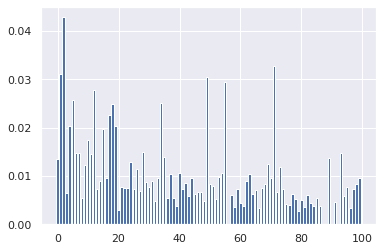

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  1.8min finished


[15:17:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                   iid=False, n_iter=10, n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0

The best params are: {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 3, 'max_depth': 9, 'gamma': 0.0, 'colsample_bytree': 0.8}
 The best score(MSE) is:0.3016703109205973


In [157]:
model = models['xgb']
model.fit(train_X_encoded, train_Y)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

params = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

automl = False
normal = True
meta = False
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model,random_state=0,n_jobs =4, param_distributions=params,verbose= 3, cv=3, scoring = 'neg_mean_squared_error',iid=False)
random_search.fit(train_X_encoded, train_Y)

print('The best params are: {0}\n The best score(MSE) is:{1}'.format(random_search.best_params_,-random_search.best_score_))

#  The best score(MSE) is:0.2752193451169078

In [161]:
automl = False
normal = True
meta = False
# random_search = False

random_search = models['svm']
random_search.fit(train_X_encoded, train_Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
# 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

# param_grid ={'C': [0.1, 1, 10, 100, 1000],  
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
random_search2 = RandomizedSearchCV(SVR(), param_distributions=param_grid, n_iter=5, cv=3,n_jobs= 5, scoring = 'neg_mean_squared_error',verbose =10)
random_search2.fit(train_X_encoded, train_Y)

print('The best params are: {0}\n The best score(MSE) is:{1}'.format(random_search2.best_params_,-random_search2.best_score_))

In [0]:
automl = False
normal = True
meta = False

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=random_grid, cv=3,n_jobs=-1,verbose= 3,scoring = 'neg_mean_squared_error')
random_search.fit(train_X_encoded, train_Y)

print('The best params are: {0}\n The best score(MSE) is:{1}'.format(random_search.best_params_,-random_search.best_score_))


The best params are: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
 The best score(MSE) is:0.2857141662335108


## Model Building Using AutoML

In [129]:
!pip install h2o

     |████████████████████████████████| 123.6MB 94kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.8-py2.py3-none-any.whl size=123708939 sha256=3cdbd3e96090f7f2695935da94fb8994ef9e44ef3c319059e197909084e1f945
  Stored in directory: /root/.cache/pip/wheels/f7/4c/2f/367de2996c0c2621a9e2e19624be0ea0e4b766df3cd597d916
Successfully built h2o


In [165]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,32 mins 23 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_unknownUser_ip7lmi
H2O cluster total nodes:,1
H2O cluster free memory:,15.94 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


In [166]:
train_D = h2o.H2OFrame(train_X_scaled.join(train_Y))
test_D = h2o.H2OFrame(test_X_scaled)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [167]:
cat = list(train_X_scaled.select_dtypes(['object']).columns)
cat

['Edition_Type_Blind_Group', 'BookCategory', 'Month', 'Wk_day', 'Yr_wk']

In [0]:
x = list(train_X_scaled.columns)
y = 'Logged_Price'
# For binary classification, response should be a factor
# train_D[y] = train_D[y].asfactor()

In [169]:
aml = H2OAutoML(max_models=100, seed=25, max_runtime_secs=60*5)
aml.train(x=x, y=y, training_frame=train_D)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [170]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

# StackedEnsemble_AllModels_AutoML_20191028_152154	0.258016	0.507953	0.258016	0.364059	0.0723268
# StackedEnsemble_BestOfFamily_AutoML_20191028_152154	0.259123	0.509041	0.259123	0.365434	0.0724928

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20191028_152154,0.258016,0.507953,0.258016,0.364059,0.0723268
StackedEnsemble_BestOfFamily_AutoML_20191028_152154,0.259123,0.509041,0.259123,0.365434,0.0724928
XGBoost_2_AutoML_20191028_152154,0.2604,0.510294,0.2604,0.365746,0.0726283
XGBoost_1_AutoML_20191028_152154,0.262861,0.5127,0.262861,0.36863,0.0730143
XGBoost_3_AutoML_20191028_152154,0.27176,0.521306,0.27176,0.386254,0.0742562
GLM_grid_1_AutoML_20191028_152154_model_1,0.327838,0.572572,0.327838,0.431871,0.081921


In [171]:
preds = aml.predict(test_D)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [0]:
y_pred = preds['predict'].as_data_frame().values
automl = True
normal = False
meta = False

## Meta Model

In [0]:
meta_data = pd.DataFrame()
meta_data['XGB'] = np.expm1(random_search.predict(train_X_encoded))
meta_data['RF'] = np.expm1(random_search3.predict(train_X_encoded))
meta_data['SVM'] = np.expm1(random_search2.predict(train_X_encoded))
meta_data['target'] = train_Y
meta_data.head()

In [0]:
meta_data.isna().sum()

In [0]:
cols = ['XGB','RF','SVM']
meta_scaler = StandardScaler()
meta_data_scaled = pd.DataFrame(meta_scaler.fit_transform(meta_data[cols]), columns =cols)
meta_data_scaled.head()

In [0]:
meta= True
automl = False
normal = False

# from sklearn.model_selection import RandomizedSearchCV
# meta_random_search = RandomizedSearchCV(XGBRegressor(),random_state=0, param_distributions=params, cv=5, scoring = 'neg_mean_squared_error',iid=False)
# meta_random_search.fit(meta_data_scaled, train_Y)
# print('The best params are: {0}\n The best score(MSE) is:{1}'.format(meta_random_search.best_params_,-meta_random_search.best_score_))

meta_model = LinearRegression()
meta_model.fit(meta_data_scaled[['XGB','RF']], train_Y)

In [0]:
meta_test = pd.DataFrame()
meta_test['XGB'] = np.expm1(random_search.predict(test_X_encoded))
meta_test['SVM'] = np.expm1(random_search2.predict(test_X_encoded))
meta_test['RF'] = np.expm1(random_search3.predict(test_X_encoded))
meta_test.shape
meta_test.head()


In [0]:
meta_test_scaled = pd.DataFrame(meta_scaler.transform(meta_test), columns =cols)
meta_test_scaled.head()
meta_test_scaled.shape

## Evaluation

RMSE : 188.17417488878837, RMSLE : 0.1200954404403692, R2 : 0.8896505596376


<Figure size 864x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

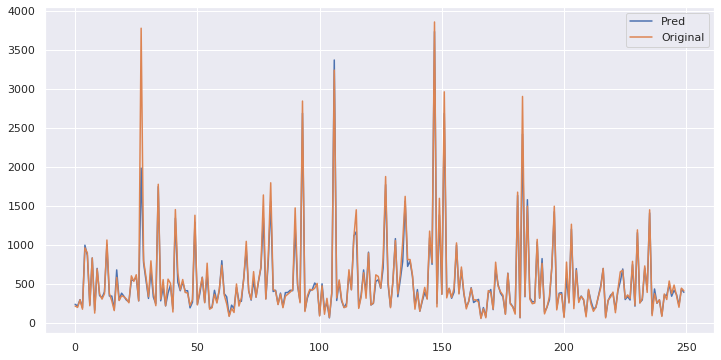

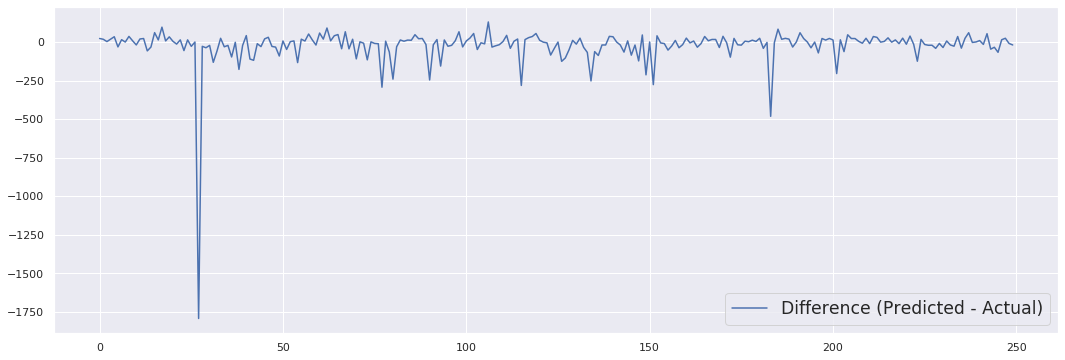

In [119]:
 train_Y_hat = np.expm1(random_search.predict(train_X_encoded))
  #  (np.expm1(random_search.predict(test_X_encoded)) + \
  # np.expm1(random_search2.predict(test_X_encoded))+\
  # np.expm1(random_search3.predict(test_X_encoded)))/3

# if outlier:
#     train_Y_actual = train['Price'][normal_index]
# else:
#     train_Y_actual = train['Price']
print('RMSE : {0}, RMSLE : {1}, R2 : {2}'.format(sqrt(mean_squared_error(train_Y_hat,train['Price'])),\
                                       sqrt(mean_squared_log_error(train_Y_hat,train['Price'])),\
                                                r2_score(train_Y_hat, train['Price'])))

# RMSE : 321.77229485404524, RMSLE : 0.1967917810608369, R2 : 0.5137072720695255

plt.figure(figsize=(12,6))
plt.plot(train_Y_hat[:250],label='Pred')
plt.plot(train['Price'][:250], label = 'Original')
plt.legend(loc = 'best')

diff = [a-b for (a,b) in zip(train_Y_hat,train['Price'])]

plt.figure(figsize=(18,6))
plt.plot(diff[:250],label='Difference (Predicted - Actual)')
plt.legend(loc='best',fontsize= 'x-large')

## Prediction and Submission

In [173]:
normal, automl, meta

(False, True, False)

In [174]:
# set(test_X_encoded.columns) ^ set(train_X_encoded.columns)

if normal:
#     test_Y_hat = 0.7*np.expm1(random_search.predict(test_X_encoded))+0.3*np.expm1(random_search.predict(test_X_encoded)
    test_Y_hat = np.expm1(random_search.predict(test_X_encoded))
    print('Predicted Using XGB')
elif automl:
    test_Y_hat = np.expm1(y_pred)
    print("Predicted using AutoML")
elif meta:
    test_Y_hat =np.expm1(meta_model.predict(meta_test_scaled[['XGB','RF']]))
    print('Predicted using Meta')
submit.head()

submit['Price'] = test_Y_hat
submit.head()

submit.to_excel('submission62.xlsx',index= False)

Predicted using AutoML


,Price
0,324.457468
1,603.295537
2,961.808643
3,385.609289
4,517.046590


,Price
0,416.807014
1,1560.667202
2,311.860967
3,852.291403
4,226.574731


## Hacks

In [175]:
if train.index.name!='Title':
  train.set_index('Title', inplace =True)

# train.head()

fake_submission = [-1]*test.shape[0]

count = 0
for i,title in enumerate(test['Title']):
    try:
        fake_submission[i] = np.mean(train['Price'][title])
        count+=1
    except:
        fake_submission[i] = -1
        
print('Total {0} values replaced'.format(count))

if train.index.name=='Title':
  train.reset_index(inplace =True)
# train.head()

fake_submission_pd = pd.DataFrame(fake_submission, columns = ['Price'])
fake_submission_pd.to_csv('fake_submission.csv', index =False)
fake_submission_pd.head()

submit2 = pd.read_csv('submission.csv')
submit2['Price'] = [hacked if hacked != -1 else float(pred) for (pred, hacked) in zip(test_Y_hat, fake_submission)]
submit2.head()

submit2.to_excel('submission62_hacked.xlsx', index = False)

sqrt(mean_squared_log_error(submit2['Price'],submit['Price']))

# 0.08115916199649

Total 316 values replaced


,Price
0,488.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0


,Price
0,488.000000
1,1560.667202
2,311.860967
3,852.291403
4,226.574731


0.07666419890190326

## Saving Model

In [0]:
import pickle
# now you can save it to a file
with open('XGB_RandomSearch.pkl', 'wb') as f:
    pickle.dump(random_search, f)

with open('SVM_RandomSearch.pkl', 'wb') as f:
    pickle.dump(random_search2, f)

with open('RF_RandomSearch.pkl', 'wb') as f:
    pickle.dump(random_search3, f)

# # and later you can load it
# with open('filename.pkl', 'rb') as f:
#     clf = pickle.load(f)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mv *.pkl '/content/drive/My Drive/SavedModels/BooksPricePrediction/'
!ls '/content/drive/My Drive/SavedModels/BooksPricePrediction/'

## Finished 7th on the leaderboard 
### Score - 0.7895 (1- RMSLE)
### [Leaderboard](https://www.machinehack.com/course/predict-the-price-of-books/leaderboard)